## Reading FWHM PSF & Determining the PSF size

### Packages & Directories

In [1]:
import numpy as np
import glob, os
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

In [2]:
# %matplotlib widget
%matplotlib notebook

In [3]:
dir_Obj = str(Path("./Object").absolute())+"/"
path_list_obj = sorted(glob.glob(dir_Obj+"*/*"))

In [4]:
path_list_obj

['/data/jlee/NGC6946/Object/N-A-L656/2013-12-02',
 '/data/jlee/NGC6946/Object/W-C-IC/2008-08-30',
 '/data/jlee/NGC6946/Object/W-C-IC/2013-12-04',
 '/data/jlee/NGC6946/Object/W-C-IC/2014-04-29',
 '/data/jlee/NGC6946/Object/W-C-RC/2009-08-21',
 '/data/jlee/NGC6946/Object/W-C-RC/2013-12-03',
 '/data/jlee/NGC6946/Object/W-J-B/2008-09-03',
 '/data/jlee/NGC6946/Object/W-J-B/2009-08-21',
 '/data/jlee/NGC6946/Object/W-J-B/2013-12-04',
 '/data/jlee/NGC6946/Object/W-J-B/2014-04-29']

In [5]:
if (glob.glob("PSFs") == []):
    os.system("mkdir PSFs")

### Reading PSF measurement

In [6]:
def load_fwhmpsf(directory):
    # Reading PSF log files
    path = str(Path(directory).absolute())
    band = path.split("/")[-2]
    date = path.split("/")[-1]
    with open(path+"/fwhmpsf_batch.log", "r") as f:
        ll = f.readlines()
    eff_lines = pd.Series(ll).str.startswith('gfTo_')
    n_line = np.sum(eff_lines)
    fwhmpsf = np.genfromtxt(path+"/fwhmpsf_batch.log", dtype=None, encoding='ascii',
                            skip_header=4, max_rows=n_line,
                            names=("image", "mean", "bin1", "bin2", "bin3", "bin4", "bin5"))

    # Counting stars
    x_bin = np.arange(fwhmpsf['mean'].min()-0.2, fwhmpsf['mean'].max()+0.2+0.1, step=0.1)
    N_star = np.zeros_like(x_bin).astype('int')
    for i in np.arange(n_line):
        for j in np.arange(5):
            fwhm_bin = fwhmpsf['mean'][i]-0.2+0.1*j
            idx = np.abs(x_bin-fwhm_bin).argmin()
            N_star[idx] += fwhmpsf[f'bin{j+1:d}'][i]

    # Statistics
    avg = np.average(x_bin, weights=N_star)
    _min, med, Q3, _max = np.percentile(np.repeat(x_bin, N_star), [0, 50, 75, 100])

    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.step(x_bin, N_star, where='mid', linewidth=2.0)
    ax.set_ylim([0, 1.2*np.max(N_star)])
    ax.axvline(Q3, 0, 1.2*np.max(N_star), linestyle='--', linewidth=1.75, color='red', alpha=0.7)
    ax.tick_params(axis='both', labelsize=12.0)
    ax.set_xlabel("FWHM [pix]", fontsize=12.0)
    ax.set_ylabel(r"$N$", fontsize=12.0)
    ax.text(0.97, 0.94, band, fontsize=12.0, fontweight='bold',
            ha="right", va="top", transform=ax.transAxes)
    ax.text(0.97, 0.87, date, fontsize=12.0, fontweight='bold',
            ha="right", va="top", transform=ax.transAxes)
    ax.text(0.97, 0.77, f"{_min:.2f}-{_max:.2f} pix", fontsize=12.0, color='gray',
            ha="right", va="top", transform=ax.transAxes)
    ax.text(0.97, 0.70, f"Mean {avg:.2f} pix", fontsize=12.0, color='gray',
            ha="right", va="top", transform=ax.transAxes)
    ax.text(0.97, 0.63, f"Median {med:.2f} pix", fontsize=12.0, color='gray',
            ha="right", va="top", transform=ax.transAxes)
    ax.text(0.97, 0.56, f"Q3 {Q3:.2f} pix", fontsize=12.0, color='red',
            ha="right", va="top", transform=ax.transAxes)
    plt.tight_layout()
    plt.savefig("PSFs/"+band+"("+date+").png", dpi=300)
    
    return {'obs':[band, date], 'data':[x_bin, N_star], 'stat':[_min, _max, avg, med, Q3]}

<IPython.core.display.Javascript object>


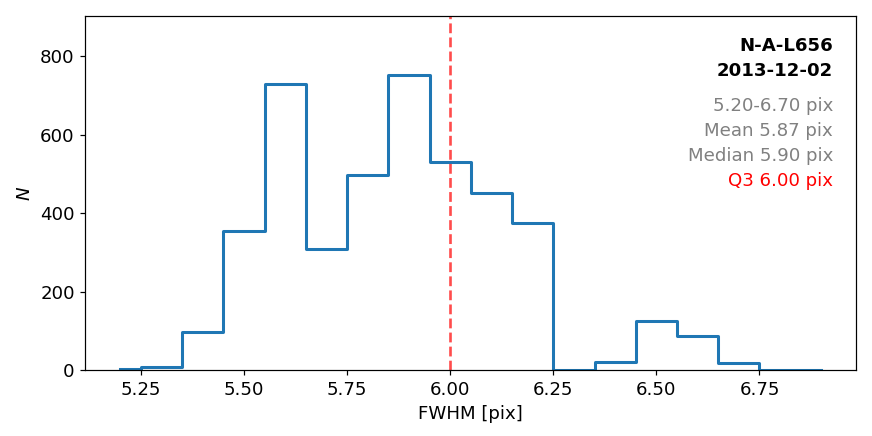

<IPython.core.display.Javascript object>


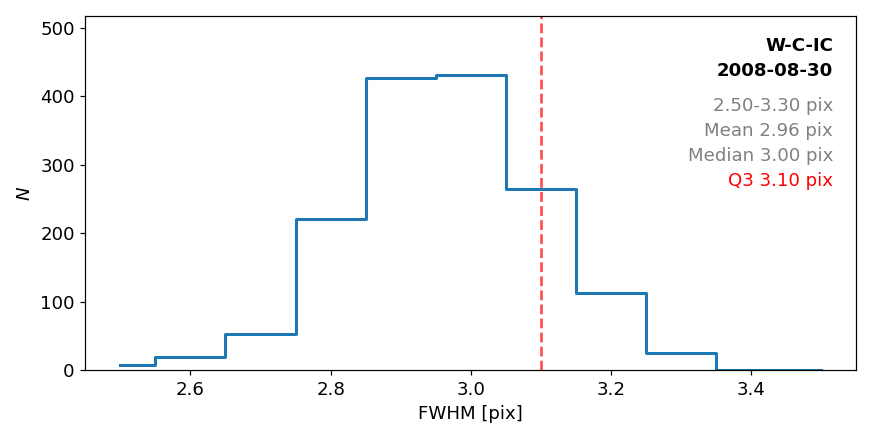

<IPython.core.display.Javascript object>


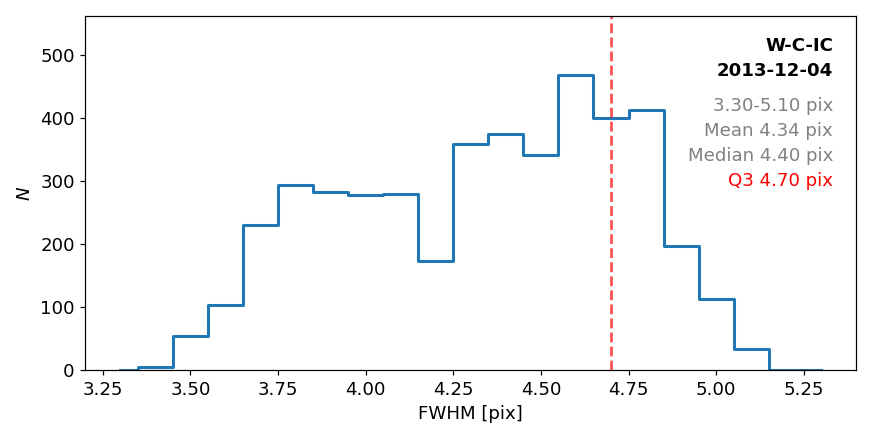

<IPython.core.display.Javascript object>


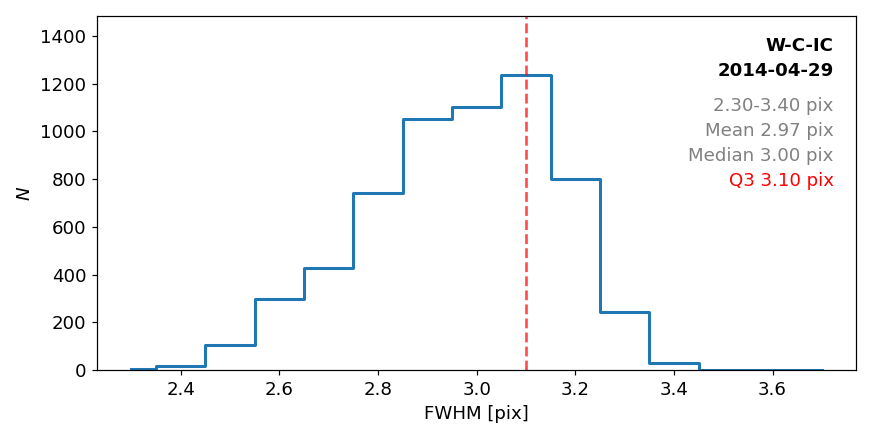

<IPython.core.display.Javascript object>


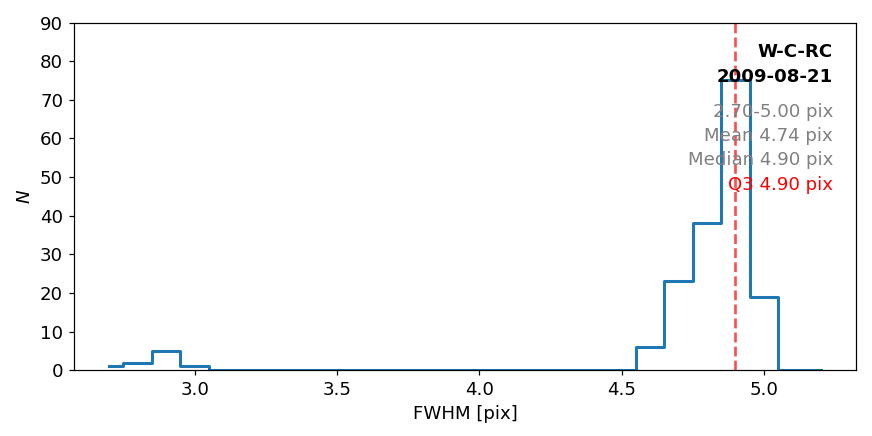

<IPython.core.display.Javascript object>


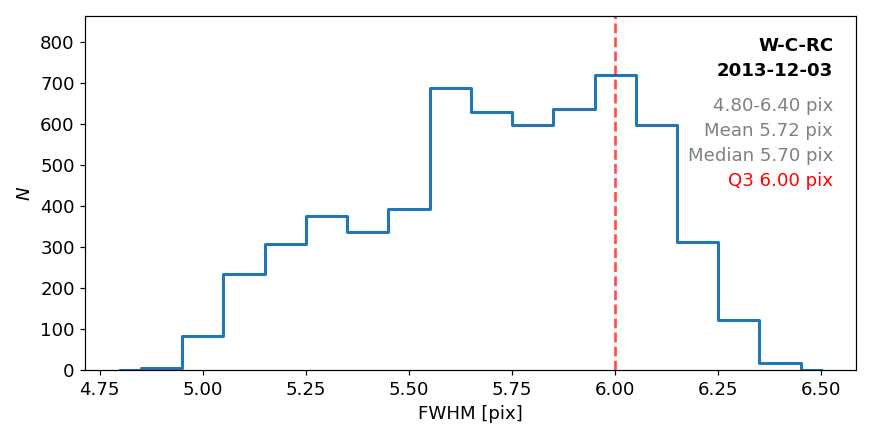

<IPython.core.display.Javascript object>


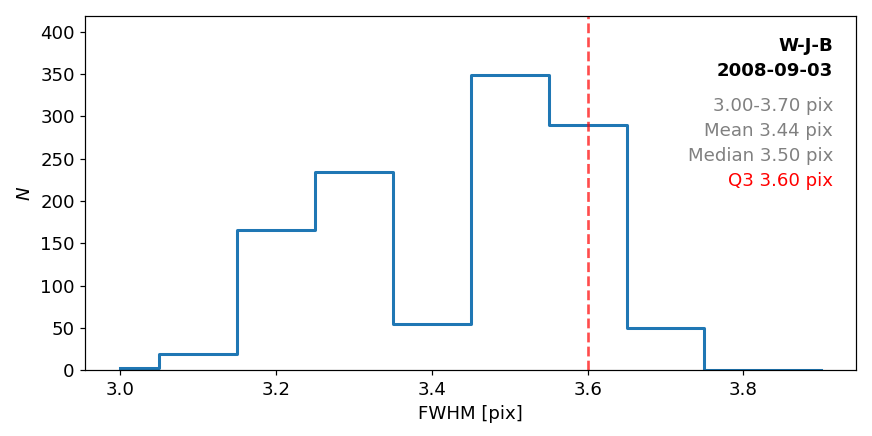

<IPython.core.display.Javascript object>


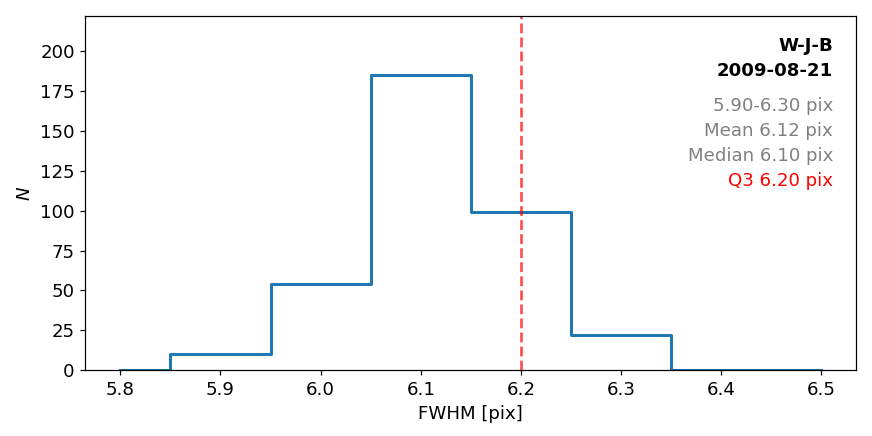

<IPython.core.display.Javascript object>


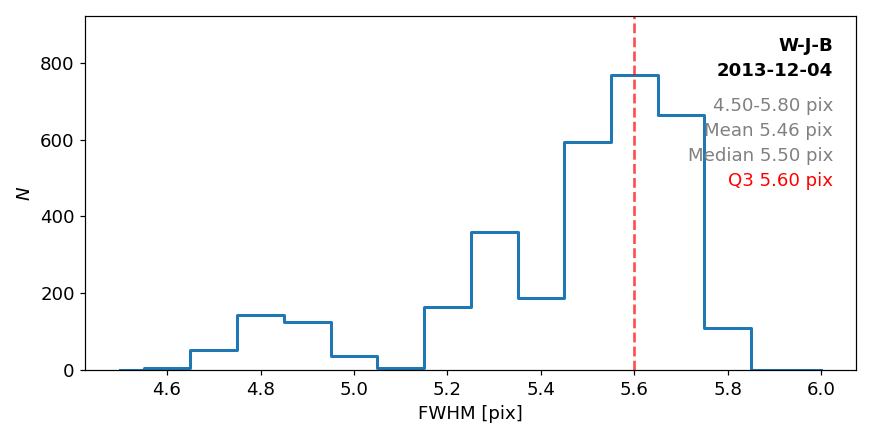

<IPython.core.display.Javascript object>


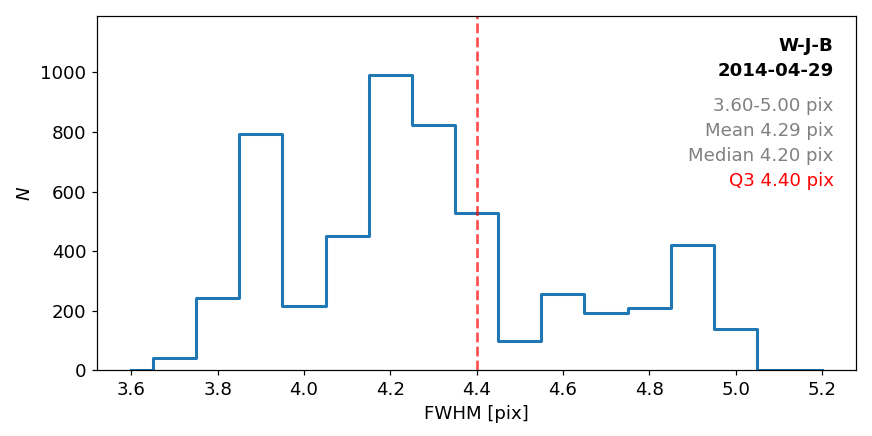

In [7]:
fwhm_q3 = []
for di in path_list_obj:
    dic = load_fwhmpsf(di)
    fwhm_q3.append(dic['stat'][-1])

### Writing the SDFRED2 scripts

In [8]:
# Writing the second script of the reduction
text1_red2_obj = "# Step 7 : Equalize the PSF size\n"
text1_red2_obj += "ls -1 gfTo_RH*.fits > psfmatch_batch.lis\n"

text2_red2_obj = "# Step 8 : Subtract the Sky Background\n"
text2_red2_obj += "ls -1 pgfTo_RH*.fits > skysb.lis\n"
text2_red2_obj += "skysb.csh skysb.lis 64\n\n"
text2_red2_obj += "# Step 9 : Mask the AG Shade\n"
text2_red2_obj += "ls -1 spgfTo_RH*.fits > mask_AGX.lis\n"
text2_red2_obj += "mask_AGX.csh mask_AGX.lis\n"

with open("red2_obj.sh", "w") as f:
    f.write(text1_red2_obj)

for i, di in enumerate(path_list_obj):
    os.system("cp -rpv red2_obj.sh "+di+"/red2.sh")
    with open(di+"/red2.sh", "a") as f:
        f.write(f"psfmatch_batch.csh psfmatch_batch.lis 50 2000 40000 2.0 7.0 {fwhm_q3[i]:.1f}\n\n")
        f.write(text2_red2_obj)

In [11]:
# Writing the second script of the reduction
text_red3_obj = "# Step 11 : Estimate Alignment and Scaling\n"
text_red3_obj += "ls -1 AspgfTo_RH*.fits > makemos.lis\n"
text_red3_obj += "makemos.csh makemos.lis 5 20 500 10000 10 all.mos\n\n"
text_red3_obj += "# Step 12 : Combine\n"
text_red3_obj += "imcio2a -dist_clip -nline=20 -dtype=FITSFLOAT -pixignr=-32768 all.mos comb.fits\n\n"
text_red3_obj += "# Removing intermediate files\n"
text_red3_obj += "rm -rfv *To*.fits tmp*\n\n"

with open("red3_obj.sh", "w") as f:
    f.write(text_red3_obj)

for i, di in enumerate(path_list_obj):
    os.system("cp -rpv red3_obj.sh "+di+"/red3.sh")